In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import safetensors
from safetensors import safe_open
import torch
from pathlib import Path
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# Baseline

In [4]:
feature_path = "/data/lux70/data/pfam/features/all.pt"
with safe_open(feature_path, "pt") as f:
    features = f.get_tensor('features')

print(features.shape)

NUM_TO_EVAL = 512
idxs = np.arange(NUM_TO_EVAL * 2)
np.random.shuffle(idxs)

idxs1 = idxs[:NUM_TO_EVAL]
idxs2 = idxs[NUM_TO_EVAL:]

gt_x1 = features[idxs1].numpy()
gt_x2 = features[idxs2].numpy()

torch.Size([11886, 32])


In [5]:
from plaid.evaluation import parmar_kid, parmar_fid, ConditionalFID

In [6]:
uncond_gt_fid = parmar_fid(gt_x1, gt_x2)
print(uncond_gt_fid)

0.004427324210236727


In [7]:
parmar_kid(gt_x1, gt_x2)

-3.0023683074134057e-05

### Unconditional to Random

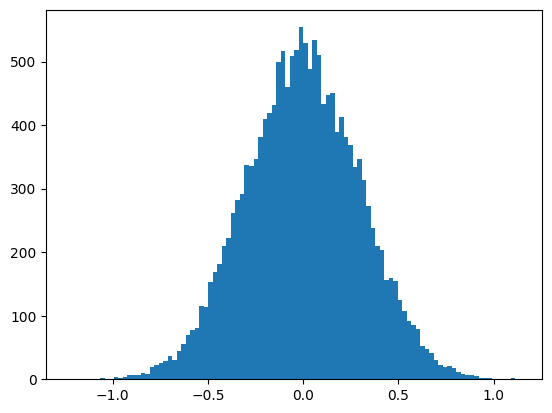

In [8]:
# from scipy.stats import beta

# # Beta distribution parameters can be tweaked for a Gaussian-like shape
# alpha, beta_param = 8, 8
# samples = beta(alpha, beta_param).rvs(1000)

# # Rescale to [-1, 1]
# bounded_samples = 2 * samples - 0.9
# print(bounded_samples.shape)
# _ = plt.hist(bounded_samples.flatten(),bins=100)


random = np.random.normal(0, 0.3, (512, 32))
_ = plt.hist(random.flatten(), bins=100)

In [9]:
random_fid = parmar_fid(random, gt_x1)
print(random_fid)

3.64562124110458


In [10]:
parmar_fid(random, gt_x2)

3.6613143722900707

# Unconditional generation performance

In [11]:
with np.load("/data/lux70/plaid/artifacts/samples/5j007z42/f2219_o3617/240907_0658/latent.npz", allow_pickle=True) as f:
    uncond_gen = f['samples']

print(uncond_gen.shape)
uncond_gen = uncond_gen.astype(np.float32)

(1024, 128, 32)


In [12]:
idxs = np.arange(len(uncond_gen))
np.random.shuffle(idxs)
uncond_gen = uncond_gen[idxs[:NUM_TO_EVAL]]
uncond_gen = uncond_gen.mean(axis=1)
print(uncond_gen.shape)

(512, 32)


In [13]:
uncond_gen_fid = parmar_fid(gt_x1, uncond_gen)
print(uncond_gen_fid)

# just to double check, use the other chunk too
print(parmar_fid(gt_x2, uncond_gen))

0.07637256839755446
0.08355992729511436


In [14]:
print(parmar_kid(gt_x1, uncond_gen))
print(parmar_kid(gt_x2, uncond_gen))

0.002485317666003457
0.002933099899739986


# Amass Conditional FID

In [15]:
from cheap.pretrained import CHEAP_pfam_shorten_2_dim_32
cheap_pipeline = CHEAP_pfam_shorten_2_dim_32()

/homefs/home/lux70/code/cheap-proteins/src/cheap/pretrained.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(checkpoint_fpath)


Using tanh layer at bottleneck...
Finished loading HPCT model with shorten factor 2 and 32 channel dimensions.
Creating ESMFold embedding only model...
ESMFold embedding only model created in 30.75 seconds


In [16]:
from plaid.evaluation import ConditionalFID
from pathlib import Path
import glob
import numpy as np
import torch
import os

samples_dir = Path("/data/lux70/plaid/artifacts/samples/5j007z42/")

In [17]:
def cond_code_to_idx(cond_code: str):
    vals = cond_code.split("_")
    return int(vals[0][1:]), int(vals[1][1:])


condgen_to_true = {}
uncond_to_true = {}

batch_size = 128


for i, cond_code in enumerate(os.listdir(samples_dir)):
    function_idx, organism_idx = cond_code_to_idx(cond_code)
    # timestamps = glob.glob(str(samples_dir / cond_code / "*.npz"))
    timestamps = os.listdir(samples_dir / cond_code)
    
    if len(timestamps) > 0:
        try:
            timestamp = timestamps[-1]
            fpath = samples_dir / cond_code / timestamp / "latent.npz"
            print(fpath)
    
            cond_fid = ConditionalFID(
                function_idx=function_idx,
                organism_idx=organism_idx,
                cheap_pipeline=cheap_pipeline,
                batch_size=batch_size,
                max_seq_len=256,
                max_eval_samples=512
            )
            
            with np.load(fpath, allow_pickle=True) as f:
                x = f['samples'].astype(np.float32)
    
            feat = x[:, -1, :, :] # take last timestep only
            feat = feat.mean(axis=1)
            res = cond_fid.run(feat)
            print(cond_code, "Generated <-> GT FID:", res)
    
            condgen_to_true[cond_code] = res
    
            # also try what happens if you do ground truth unconditional to conditional
            # res = parmar_fid(feat, gt_x1)
            res = parmar_fid(cond_fid.real, gt_x1)
            uncond_to_true[cond_code] = res
            print(cond_code, "Random Real <-> GT FID:", res)
        except Exception as e:
            print(e)
            continue
            
    else:
        pass

/data/lux70/plaid/artifacts/samples/5j007z42/f323_o3617/240915_0049/latent.npz
Found 250 samples for this condition.
Need at least 512 samples, as configured.
/data/lux70/plaid/artifacts/samples/5j007z42/f262_o3617/240913_1824/latent.npz
f262_o3617 Generated <-> GT FID: 0.5439754291324348
f262_o3617 Random Real <-> GT FID: 0.20854483835237353
/data/lux70/plaid/artifacts/samples/5j007z42/f129_o3617/240915_1611/latent.npz
f129_o3617 Generated <-> GT FID: 0.7911380707250295
f129_o3617 Random Real <-> GT FID: 0.27596326002667604
/data/lux70/plaid/artifacts/samples/5j007z42/f314_o3617/240914_1534/latent.npz
f314_o3617 Generated <-> GT FID: 0.5793643226971421
f314_o3617 Random Real <-> GT FID: 0.4751222681490862
/data/lux70/plaid/artifacts/samples/5j007z42/f356_o3617/240915_1658/latent.npz
f356_o3617 Generated <-> GT FID: 0.10862015603524137
f356_o3617 Random Real <-> GT FID: 0.24258733944868732
/data/lux70/plaid/artifacts/samples/5j007z42/f303_o3617/240914_1046/latent.npz
Found 4 samples fo

# Plot

In [18]:
# turn into dataframe
df1 = pd.DataFrame(list(condgen_to_true.items()), columns=['Key', 'condgen_to_true'])
df2 = pd.DataFrame(list(uncond_to_true.items()), columns=['Key', 'uncond_to_true'])
combined_df = pd.merge(df1, df2, on='Key')
combined_df["GO_idx"] = combined_df['Key'].map(lambda x: cond_code_to_idx(x)[0])
combined_df["organism_index"] = combined_df['Key'].map(lambda x: cond_code_to_idx(x)[1])

# attach GO metadata
go_df = pd.read_csv("/data/lux70/data/pfam/go_index.csv")
combined_df = combined_df.merge(go_df)
combined_df = combined_df.sort_values(by="count")
combined_df['delta'] = combined_df.condgen_to_true - combined_df.uncond_to_true

In [20]:
combined_df

,Key,condgen_to_true,uncond_to_true,GO_idx,organism_index,Unnamed: 0,GO_term,pfam_id,GO_id,GO_level,count,delta
2,f314_o3617,0.579364,0.475122,314,3617,1805,regulation of microtubule polymerization or de...,PF00836,GO:0031110,process,1,0.104242
5,f322_o3617,0.277121,0.308341,322,3617,1996,sucrose metabolic process,PF00862,GO:0005985,process,1,-0.031219
11,f106_o3617,0.894699,0.373063,106,3617,2128,tumor necrosis factor receptor binding,PF00229,GO:0005164,function,1,0.521636
8,f315_o3617,0.483112,0.213841,315,3617,2062,thyroxine 5'-deiodinase activity,PF00837,GO:0004800,function,1,0.269271
15,f342_o3617,0.805613,0.257172,342,3617,1177,methylthiotransferase activity,PF00919,GO:0035596,function,1,0.548441
26,f364_o3617,0.500429,0.494000,364,3617,2123,troponin complex,PF00992,GO:0005861,component,1,0.006429
27,f267_o3617,0.526766,0.433604,267,3617,2153,urease complex,PF00699,GO:0035550,component,1,0.093162
31,f140_o3617,0.668268,0.279113,140,3617,2125,tryptophan synthase activity,PF00290,GO:0004834,function,1,0.389155
25,f352_o3617,0.821810,0.385058,352,3617,1761,recognition of pollen,PF00954,GO:0048544,process,1,0.436751
20,f290_o3617,0.748414,0.264787,290,3617,1175,methylenetetrahydrofolate dehydrogenase (NADP+...,PF00763,GO:0004488,function,2,0.483627


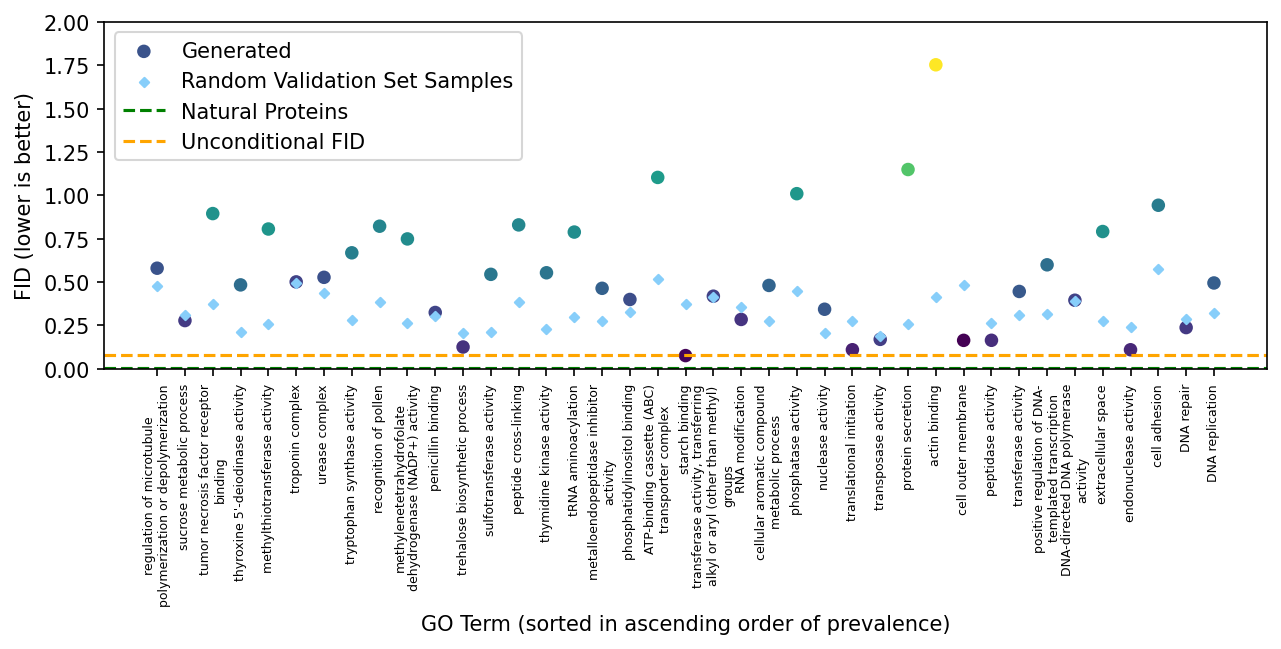

In [38]:
import textwrap

from matplotlib import cm
from matplotlib.colors import Normalize

values = combined_df['delta']
norm = Normalize(vmin=min(values), vmax=max(values))

colormap = cm.viridis  # You can replace 'viridis' with any other matplotlib colormap
colors = colormap(norm(values))


fig, ax = plt.subplots(1, 1, dpi=150, figsize=(10,3))
ax.scatter(np.arange(len(combined_df)), combined_df['condgen_to_true'].values, label="Generated", s=30, c=colors)
# ax.scatter(np.arange(len(combined_df)), combined_df['uncond_to_true'].values, label="Random Validation Set Samples",s=15, c=colors, marker="D")
ax.scatter(np.arange(len(combined_df)), combined_df['uncond_to_true'].values, label="Random Validation Set Samples",s=10, c="lightskyblue", marker="D")

x_labels = combined_df.GO_term.values
wrapped_labels = ['\n'.join(textwrap.wrap(label, width=35)) for label in x_labels]

ax.set_xticks(ticks=np.arange(len(combined_df)), labels=wrapped_labels, rotation=90, fontsize=6)

ax.axhline(y=uncond_gt_fid, color='green', linestyle='--', label="Natural Proteins")
ax.axhline(y=uncond_gen_fid, color='orange', linestyle='--', label="Unconditional FID")


### TODO: modify upper bound on y lim as needed
### TODO: wrap text?

ax.set_ylim(0,2.0)
ax.set_xlabel("GO Term (sorted in ascending order of prevalence)")
ax.set_ylabel("FID (lower is better)")

plt.legend()

In [42]:
" ".join(combined_df[combined_df.delta < 0].Key.values)

'f322_o3617 f362_o3617 f263_o3617 f319_o3617 f269_o3617 f327_o3617 f308_o3617 f349_o3617 f356_o3617 f307_o3617'

In [23]:
combined_df.to_csv("~/cond_fid_tmp.csv", sep=",")

# Across Sampling Timesteps

In [26]:
!ls /data/lux70/plaid/artifacts/samples/5j007z42/

f102_o3617  f129_o3617	 f283_o3617  f303_o3617  f322_o3617  f341_o3617
f106_o3617  f2219_o3617  f287_o3617  f307_o3617  f323_o3617  f342_o3617
f111_o3617  f262_o3617	 f288_o3617  f308_o3617  f324_o3617  f349_o3617
f113_o3617  f263_o3617	 f290_o3617  f314_o3617  f325_o3617  f350_o3617
f115_o3617  f265_o3617	 f291_o3617  f315_o3617  f327_o3617  f352_o3617
f123_o3617  f267_o3617	 f296_o3617  f317_o3617  f336_o3617  f356_o3617
f124_o3617  f269_o3617	 f300_o3617  f319_o3617  f337_o3617


In [27]:
latent_path = Path("/data/lux70/plaid/artifacts/samples/5j007z42/f2219_o3617/240915_0802/latent.npz")

with np.load(latent_path) as f:
    x = f['samples']

In [28]:
from tqdm.notebook import trange

fids = []

for i in trange(x.shape[1]): # across timesteps
    lat = x[:, i, :, :]
    fid = parmar_fid(gt_x1, lat.mean(axis=1))
    fids.append(fid)

print(fids[-1])

  0%|          | 0/128 [00:00<?, ?it/s]

IndexError: too many indices for array: array is 3-dimensional, but 4 were indexed

In [ ]:
fig,ax = plt.subplots(1,1,dpi=200, figsize=(4,4))
ax.plot(fids)
ax.set_xlabel("Sampling Timestep")
ax.set_ylabel("FID")